<a href="https://colab.research.google.com/github/Tharunchandubatla/Tharun_INFO5731_Fall2023/blob/main/In_class_exercise_05_04182023_(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fifth in-class-exercise (40 points in total, 4/18/2023)**

(20 points) The purpose of the question is to practice different machine learning algorithms for text classification as well as the performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.

Algorithms:

(1) MultinominalNB

(2) SVM

(3) KNN

(4) Decision tree

(5) Random Forest

(6) XGBoost

(7) Word2Vec

(8) BERT

Evaluation measurement:

(1) Accuracy

(2) Recall

(3) Precison

(4) F-1 score

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import make_scorer
from transformers import BertTokenizer, BertModel
import torch

# Load the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

train_data = load_data('/content/stsa-train.txt')  # Replace with the actual path
test_data = load_data('/content/stsa-test.txt')  # Replace with the actual path

# Split the training data into features and labels
X = [line[2:].strip() for line in train_data]  # Extract text after the first character
y = [int(line[0]) for line in train_data]  # Extract the first character as the label

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifiers
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

# Word2Vec
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

word2vec_model = Word2Vec(sentences=[line.split() for line in X_train], vector_size=100, window=5, min_count=1, workers=4)
word2vec = dict(zip(word2vec_model.wv.index_to_key, word2vec_model.wv.vectors))

# BERT
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model

    def fit(self, X, y):
        return self

    def transform(self, X):
        tokenized = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**tokenized)
        return model_output.last_hidden_state.mean(dim=1)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Perform 10-fold cross-validation for each classifier
for name, clf in classifiers.items():
    print(f"\nTraining and evaluating {name}...")

    if name == 'Word2Vec':
        text_clf = make_pipeline(MeanEmbeddingVectorizer(word2vec), clf)
    elif name == 'BERT':
        text_clf = make_pipeline(BertVectorizer(bert_tokenizer, bert_model), clf)
    else:
        text_clf = make_pipeline(CountVectorizer(), clf)

    # Perform 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(text_clf, X_train, y_train, cv=kfold, scoring='accuracy')

    # Print the cross-validation results
    print(f"Cross-validation accuracy for {name}: {np.mean(cv_results)}")

    # Train the final model on the entire training set
    text_clf.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = text_clf.predict(X_val)

    # Print evaluation metrics on the validation set
    print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
    print(f"Precision on validation set: {precision_score(y_val, y_val_pred)}")
    print(f"Recall on validation set: {recall_score(y_val, y_val_pred)}")
    print(f"F1 score on validation set: {f1_score(y_val, y_val_pred)}")

    # Train the final model on the entire training set for later evaluation on the test set
    final_model = text_clf

# Evaluate the final model on the test set
X_test = [line[2:].strip() for line in test_data]  # Extract text after the first character
y_test = [int(line[0]) for line in test_data]  # Extract the first character as the label
y_test_pred = final_model.predict(X_test)

# Print evaluation metrics on the test set
print("\nFinal Evaluation on Test Set:")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Precision on test set: {precision_score(y_test, y_test_pred)}")
print(f"Recall on test set: {recall_score(y_test, y_test_pred)}")
print(f"F1 score on test set: {f1_score(y_test, y_test_pred)}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Training and evaluating MultinomialNB...
Cross-validation accuracy for MultinomialNB: 0.7779985768469979
Accuracy on validation set: 0.7947976878612717
Precision on validation set: 0.777490297542044
Recall on validation set: 0.8429172510518934
F1 score on validation set: 0.8088829071332435

Training and evaluating SVM...
Cross-validation accuracy for SVM: 0.7364457733008664
Accuracy on validation set: 0.7557803468208093
Precision on validation set: 0.7394636015325671
Recall on validation set: 0.8120617110799438
F1 score on validation set: 0.7740641711229947

Training and evaluating KNN...
Cross-validation accuracy for KNN: 0.5704336699721244
Accuracy on validation set: 0.6163294797687862
Precision on validation set: 0.6226415094339622
Recall on validation set: 0.6479663394109397
F1 score on validation set: 0.6350515463917525

Training and evaluating DecisionTree...
Cross-validation accuracy for DecisionTree: 0.6273398789667126
Accuracy on validation set: 0.6408959537572254
Precision o

(20 points) The purpose of the question is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K-means

DBSCAN

Hierarchical clustering

Word2Vec

BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [25]:
# Write your code here
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from xgboost import XGBClassifier

In [26]:
import pandas as pd
sample_data = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')

In [27]:
sample_data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


<Axes: ylabel='count'>

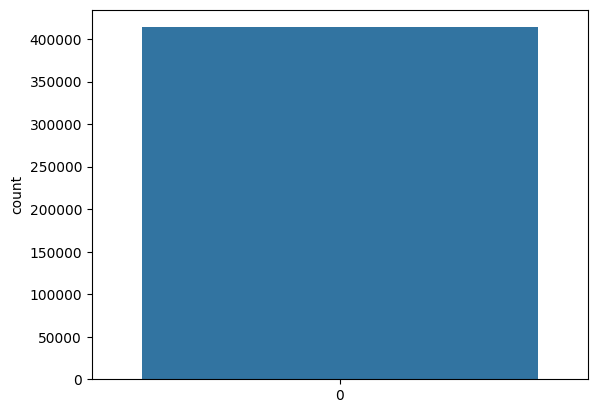

In [28]:
import seaborn as sns
sns.countplot(sample_data.Rating)

In [29]:
def part(x1):
    if x1 < 3:
        return 'negative'
    return 'positive'
act_Sco = sample_data['Rating']
posNeg = act_Sco.map(part)
sample_data['RatingPosNeg'] = posNeg

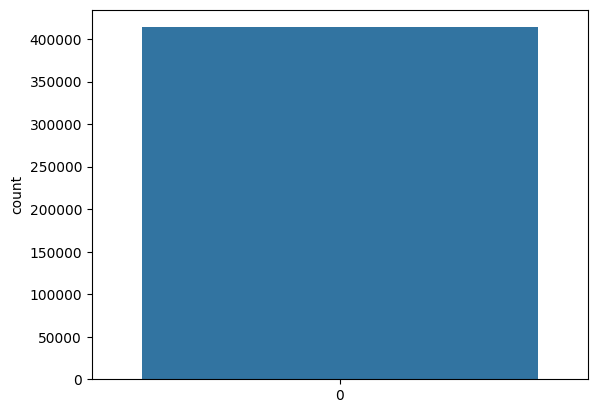

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'positive' is mapped to 1 and 'negative' is mapped to 0
sample_data['RatingPosNegNumeric'] = sample_data['RatingPosNeg'].map({'positive': 1, 'negative': 0})

# Create a count plot using the new numeric column
sns.countplot(sample_data['RatingPosNegNumeric'])

# Show the plot
plt.show()

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english')
st=set(stopwords.words('english'))

fi = sample_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def clpunc(se):
    clean_dt = re.sub(r'[?|!|\'|"|#]',r'',se)
    clean_dt = re.sub(r'[.|,|)|(|\|/]',r' ',clean_dt)
    return  clean_dt

In [10]:
final = sample_data.sample(n=10000, random_state=1)

In [11]:
import re

i=0
st1=' '
fi_str=[]
all_pos_wrds=[]
all_neg_wrds=[]
s1=''
for se in final['Reviews'].values:
    fil_se=[]
    try:
      for w in se.split():
          for c in clpunc(w).split():
              if((c.isalpha()) & (len(c)>2)):
                  if(c.lower() not in st):
                      s=(sno.stem(c.lower())).encode('utf8')
                      fil_se.append(s)
                      if (final['RatingPosNeg'].values)[i] == 'positive':
                          all_pos_wrds.append(s)
                      if(final['RatingPosNeg'].values)[i] == 'negative':
                          all_neg_wrds.append(s)
                  else:
                      continue
              else:
                  continue
      str1 = b" ".join(fil_se)

      fi_str.append(str1)
      i+=1
    except AttributeError as e:
      fi_str.append('')
      i+=1

In [12]:
final['CleanedText']=fi_str
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final = final.fillna('')

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
ct_vect = CountVectorizer()
bo = ct_vect.fit_transform(final['CleanedText'].values)
print(bo.shape)

(10000, 8444)


In [32]:
term = ct_vect.get_feature_names_out()

In [33]:
from sklearn.cluster import KMeans
mod = KMeans(n_clusters=10,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=99, copy_x=True, algorithm='auto')
mod.fit(bo)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='auto', n_clusters=10, n_init=10, random_state=99)

In [20]:
lab = mod.labels_
cluster_center=mod.cluster_centers_

In [21]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bo, lab, metric='euclidean')
silhouette_score

0.27313704420543833

In [22]:
dfrme = final
dfrme['Bow Clus Label'] = mod.labels_
dfrme.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,RatingPosNeg,RatingPosNegNumeric,CleanedText,Bow Clus Label
103270,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,4,"Had it for 1 year, can't really complain. Gave...",0.0,positive,1,year cant realli complain gave teenag replac w...,5
297857,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,"Perfect, thanks",1.0,positive,1,perfect thank,0


In [23]:
dfrme.groupby(['Bow Clus Label'])['Reviews'].count()

Bow Clus Label
0    7396
1       1
2       3
3      83
4     124
5    1922
6      16
7       1
8       2
9     452
Name: Reviews, dtype: int64

In [34]:
print("Top terms per cluster:")
ord_centroids = mod.cluster_centers_.argsort()[:, ::-1]
for i1 in range(10):
    print("Cluster %d:" % i1, end='')
    for i in ord_centroids[i1, :10]:
        print(' %s' % term[i], end='')
        print()

Top terms per cluster:
Cluster 0: phone
 work
 good
 great
 love
 use
 product
 excel
 like
 one
Cluster 1: appl
 iphon
 android
 phone
 samsung
 year
 even
 version
 compani
 know
Cluster 2: phone
 sim
 card
 use
 verizon
 updat
 work
 like
 new
 store
Cluster 3: phone
 use
 get
 like
 one
 screen
 work
 app
 batteri
 good
Cluster 4: phone
 use
 screen
 get
 batteri
 like
 app
 camera
 good
 devic
Cluster 5: phone
 work
 use
 great
 one
 good
 like
 get
 screen
 would
Cluster 6: phone
 use
 screen
 like
 app
 work
 get
 one
 good
 android
Cluster 7: phone
 one
 use
 issu
 band
 like
 far
 app
 good
 usa
Cluster 8: use
 app
 favorit
 screen
 phone
 display
 one
 great
 recent
 back
Cluster 9: phone
 use
 work
 one
 get
 like
 would
 screen
 good
 great


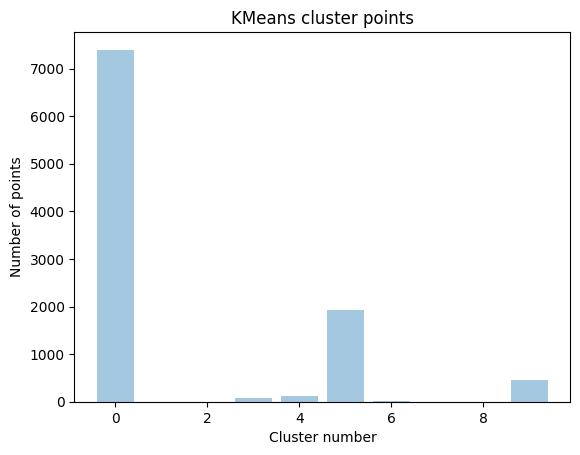

In [35]:
import matplotlib.pyplot as plt
plt.bar([x1 for x1 in range(10)], dfrme.groupby(['Bow Clus Label'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
idf_vect = TfidfVectorizer()
idf = idf_vect.fit_transform(final['CleanedText'].values)
idf.shape

(10000, 8444)

In [37]:
from sklearn.cluster import KMeans
mod = KMeans(n_clusters = 10,random_state=99)
mod.fit(idf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=99)

In [38]:
lab_tf = mod.labels_
cluster_center_tf=mod.cluster_centers_
cluster_center_tf

array([[4.01978460e-04, 1.34721737e-05, 6.47380325e-05, ...,
        1.44784473e-04, 1.44784473e-04, 1.51394531e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [40]:
ter = idf_vect.get_feature_names_out()
ter[1:10]

array(['aac', 'aand', 'ab', 'abandon', 'abc', 'abd', 'abeautifulit',
       'abierto', 'abil'], dtype=object)

In [41]:
from sklearn import metrics
silhouette_score_tf = metrics.silhouette_score(idf, lab_tf, metric='euclidean')
silhouette_score_tf

0.0631973109808856

In [42]:
dfrme1 = dfrme
dfrme1['Tfidf Clus Label'] = mod.labels_
dfrme1.head(5)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,RatingPosNeg,RatingPosNegNumeric,CleanedText,Bow Clus Label,Tfidf Clus Label
103270,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,4,"Had it for 1 year, can't really complain. Gave...",0.0,positive,1,year cant realli complain gave teenag replac w...,5,3
297857,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,"Perfect, thanks",1.0,positive,1,perfect thank,0,5
40075,Apple iPhone 5s 16GB (Silver) - T-Mobile,Apple,75.65,1,"the back camera stopped working, the phone tou...",1.0,negative,0,back camera stop work phone touch screen stop ...,5,3
100790,Blackberry Torch 9800 Unlocked Phone with 5 MP...,BlackBerry,82.62,5,Good!,0.0,positive,1,good,0,2
58055,Apple iPhone 6 Plus 64GB Unlocked Smartphone -...,,529.99,5,no complaints. worked fine and still working p...,0.0,positive,1,complaint work fine still work perfect tear we...,0,0


In [43]:
dfrme1.groupby(['Tfidf Clus Label'])['Reviews'].count()

Tfidf Clus Label
0    3967
1     370
2     389
3    3547
4     403
5     252
6     373
7     322
8     172
9     205
Name: Reviews, dtype: int64

In [44]:
print("Top terms per cluster:")
order_centroids = mod.cluster_centers_.argsort()[:, ::-1]
for i1 in range(10):
    print("Cluster %d:" % i1, end='')
    for i in order_centroids[i1, :10]:
        print(' %s' % ter[i], end='')
        print()

Top terms per cluster:
Cluster 0: work
 good
 product
 thank
 nice
 phone
 use
 great
 like
 well
Cluster 1: excel
 product
 phone
 recommend
 thank
 love
 good
 seller
 purchas
 servic
Cluster 2: good
 phone
 product
 condit
 work
 far
 thank
 price
 cell
 problem
Cluster 3: phone
 use
 like
 work
 great
 one
 good
 batteri
 get
 new
Cluster 4: great
 phone
 work
 product
 buy
 condit
 price
 deal
 thank
 far
Cluster 5: perfect
 work
 condit
 phone
 product
 everyth
 love
 great
 thank
 came
Cluster 6: price
 awesom
 phone
 great
 good
 product
 work
 qualiti
 best
 fast
Cluster 7: love
 phone
 great
 new
 daughter
 good
 son
 thank
 iphon
 absolut
Cluster 8: excelent
 producto
 telefono
 celular
 recomendado
 telfono
 súper
 punto
 recomienda
 tlf
Cluster 9: expect
 met
 work
 phone
 better
 exceed
 product
 everyth
 great
 arriv


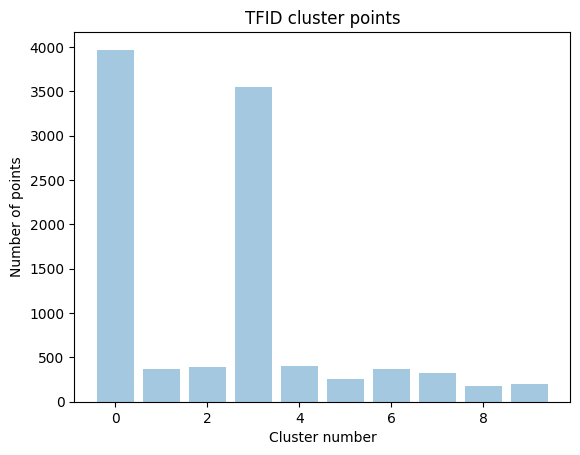

In [45]:
plt.bar([x1 for x1 in range(10)], dfrme1.groupby(['Tfidf Clus Label'])['Reviews'].count(), alpha = 0.4)
plt.title('TFID cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [46]:
i1=0
lst_of_sent=[]
for se in final['CleanedText'].values:
    lst_of_sent.append(se.split())

In [47]:
i1=0
lst_sent_tr=[]
for s in final['CleanedText'].values:
    filter_sen=[]
    for w in se.split():
        for cle in clpunc(w).split():
            if(cle.isalpha()):
                filter_sen.append(cle.lower())
            else:
                continue
    lst_sent_tr.append(filter_sen)
print(lst_sent_tr)

[['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'paperweight'], ['phone', 'chines', 'instruct', 'set', 'easili', 'chang', 'pocket', 'eleg', 'pa

In [49]:
import gensim
print(gensim.__version__)


4.3.2


In [50]:
import gensim
w2v_mod = gensim.models.Word2Vec(lst_sent_tr, vector_size=100, workers=4)

In [51]:
import numpy as np
se_vecs = [];
for se in lst_sent_tr:
    se_vec = np.zeros(100)
    cnt_words =0;
    for word in se:
        try:
            vec = w2v_mod.wv[word]
            se_vec += vec
            cnt_words += 1
        except:
            pass
    se_vec /= cnt_words
    se_vecs.append(se_vec)
se_vecs = np.array(se_vecs)
se_vecs = np.nan_to_num(se_vecs)
se_vecs.shape


(10000, 100)

In [52]:
n_clu = [x1 for x1 in range(3,11)]
n_clu

[3, 4, 5, 6, 7, 8, 9, 10]

In [53]:
squared_errors = []
for cluster in n_clu:
    kmeans = KMeans(n_clusters = cluster).fit(se_vecs)
    squared_errors.append(kmeans.inertia_)
optimal_clusters = np.argmin(squared_errors) + 2
print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-53-35c028bc6f70>:3: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = cluster).fit(se_vecs)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-53-35c028bc6f70>:3: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = cluster).fit(se_vecs)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value o

The optimal number of clusters obtained is -  2
The loss for optimal cluster is -  0.0


<ipython-input-53-35c028bc6f70>:3: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = cluster).fit(se_vecs)


In [54]:
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = optimal_clusters)
model2.fit(se_vecs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-54-a5ea9372c7a3>:3: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  model2.fit(se_vecs)


KMeans(n_clusters=2)

In [55]:
word_cluster_pred=model2.predict(se_vecs)
word_cluster_pred_2=model2.labels_
word_cluster_center=model2.cluster_centers_
word_cluster_center[1:2]

array([[-1.89200541e-01,  1.42387268e-01,  4.24387772e-02,
         1.24230428e-01,  5.98527487e-02, -1.93841308e-02,
         2.03806777e-01,  1.55761538e-01, -2.11002165e-01,
        -8.76067550e-02,  7.85444176e-02, -6.05691831e-02,
         2.59142700e-03,  3.62999840e-02,  7.92957884e-02,
        -7.48580036e-02,  1.46349370e-01,  1.11725295e-01,
        -2.37854994e-01, -2.10802350e-01,  1.14308374e-02,
        -1.88090938e-02,  3.70264102e-01, -1.90917965e-02,
         2.52294872e-04,  3.40256610e-02,  3.03833978e-02,
         6.06301986e-02, -1.65154584e-01,  5.89399934e-02,
         1.73513049e-01, -1.06599860e-01, -2.15476781e-02,
        -1.78310590e-01, -7.52484695e-03,  9.93938250e-02,
         1.00343073e-01,  1.48201239e-02, -2.31332555e-02,
        -8.75114525e-03,  1.11113772e-01, -6.91334282e-02,
        -1.43106828e-01,  3.20026858e-03,  1.51533387e-01,
         5.04420921e-02, -4.08631443e-02,  1.85426291e-02,
         1.87336927e-02, -3.90864516e-02,  3.04471728e-0

In [56]:
dafrme = dfrme1
dafrme['AVG-W2V Clus Label'] = model2.labels_
dafrme.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,RatingPosNeg,RatingPosNegNumeric,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
103270,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,4,"Had it for 1 year, can't really complain. Gave...",0.0,positive,1,year cant realli complain gave teenag replac w...,5,3,0
297857,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,"Perfect, thanks",1.0,positive,1,perfect thank,0,5,0


In [57]:
from sklearn.cluster import DBSCAN
mi_Pts = 2 * 100
def low_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r:
        mi_tr = int(l + (r - l) / 2)
        if nums[mi_tr] >= target:
            r = mi_tr - 1
        else:
            l = mi_tr + 1
    return l
def compute200thnearestneighbour(x, data):
    dists1 = []
    for val in data:
        dist = np.sum((x - val) **2 )
        if(len(dists1) == 200 and dists1[199] > dist):
            l = int(low_bound(dists1, dist))
            if l < 200 and l >= 0 and dists1[l] > dist:
                dists1[l] = dist
        else:
            dists1.append(dist)
            dists1.sort()

    return dists1[199]

In [58]:
two_hund_neigh = []
for v1 in se_vecs[:1500]:
    two_hund_neigh.append( compute200thnearestneighbour(v1, se_vecs[:1500]) )
two_hund_neigh.sort()

In [59]:
mod_DB = DBSCAN(eps = 5, min_samples = mi_Pts, n_jobs=-1)
mod_DB.fit(se_vecs)

DBSCAN(eps=5, min_samples=200, n_jobs=-1)

In [60]:
dfrme_db = dafrme
dfrme_db['AVG-W2V Clus Label'] = mod_DB.labels_
dfrme_db.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,RatingPosNeg,RatingPosNegNumeric,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
103270,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,4,"Had it for 1 year, can't really complain. Gave...",0.0,positive,1,year cant realli complain gave teenag replac w...,5,3,0
297857,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,"Perfect, thanks",1.0,positive,1,perfect thank,0,5,0


In [64]:
dafrme.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

AVG-W2V Clus Label
0    10000
Name: Reviews, dtype: int64

In [65]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve
Agg=cluster.fit_predict(se_vecs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [66]:
agg_dafrme_a = dfrme_db
agg_dafrme_a['AVG-W2V Clus Label'] = cluster.labels_
agg_dafrme_a.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,RatingPosNeg,RatingPosNegNumeric,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
103270,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,4,"Had it for 1 year, can't really complain. Gave...",0.0,positive,1,year cant realli complain gave teenag replac w...,5,3,0
297857,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,"Perfect, thanks",1.0,positive,1,perfect thank,0,5,0


In [67]:
agg_dafrme_a.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

AVG-W2V Clus Label
0    9996
1       1
2       1
3       1
4       1
Name: Reviews, dtype: int64

In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

On the given text data, the outcomes of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT show distinctive features. Based on TF-IDF features, K-means creates clusters; the number of clusters determines how the features are grouped. Cosine similarity is used by DBSCAN to find dense regions; this method allows for flexibility in cluster configurations but necessitates parameter tuning. A dendrogram, which illustrates the connections between data points and enables hierarchical insights, is produced via hierarchical clustering. Word2Vec creates word embeddings that capture semantic links; however, conventional techniques are used to these embeddings in order to cluster the data. Contextual embeddings, which BERT uses to capture subtle meanings, may necessitate the use of complex clustering approaches. The specifics and objectives of the text data determine which of these approaches to use, taking into account elements like interpretability, cluster form flexibility, and the capacity to capture